# **Modelling and Evaluation Notebook**

## Objectives

* This notebook will assess and choose which algorithm and hyperperameters are to be used for this ML task

## Inputs

* We will use the Train and Test datasets saved within outputs/datasets/train_test_initial

## Outputs

* A fully reviewed and tested model ready for dashboard

---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/Project5/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [36]:
current_dir = os.getcwd()
current_dir

'/workspaces/Project5'

---

# Model review

Compare a number of regressors and choose the best performer
* We will use:
  * Decision Tree
  * Random Forest
  * ADA Boost
  * Extra Trees
  * Gradient Boosting
  * XG Boost

In [32]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

def compare_models(features_train, target_train, features_test, target_test):
    models = {
        "DecisionTreeRegressor": DecisionTreeRegressor(random_state=101),
        "RandomForest": RandomForestRegressor(random_state=101),
        "AdaBoost": AdaBoostRegressor(random_state=101),
        "ExtraTrees": ExtraTreesRegressor(random_state=101),
        "GradientBoostingRegressor": GradientBoostingRegressor(random_state=101),
        "XGBoost": XGBRegressor(random_state=101, verbosity=0),
    }

    results = {}

    for name, model in models.items():
        print(f"\nEvaluating: {name}")

        # Pre-fit model for feature selection
        try:
            model_for_selection = model.__class__(**model.get_params())
            model_for_selection.fit(features_train, target_train)
            selector = SelectFromModel(model_for_selection, prefit=True)
        except Exception as e:
            print(f"Feature selection failed for {name}: {e}")
            selector = 'passthrough'

        pipeline = Pipeline([
            ("feat_scaling", StandardScaler()),
            ("feat_selection", selector),
            ("model", model)
        ])

        pipeline.fit(features_train, target_train)
        predictions = pipeline.predict(features_test)

        mse = mean_squared_error(target_test, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(target_test, predictions)
        r2 = r2_score(target_test, predictions)

        print(f"MSE: {mse:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"R2: {r2:.2f}")

        results[name] = {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}

    return pd.DataFrame(results).T.sort_values(by="R2", ascending=False)


Import the Train and Test sets and convert the date column, which is currently a string, to its numeric values for modelling

In [33]:
import pandas as pd

features_train = pd.read_csv("outputs/datasets/train_test_initial/features_train.csv")
features_test = pd.read_csv("outputs/datasets/train_test_initial/features_test.csv")
target_train = pd.read_csv("outputs/datasets/train_test_initial/target_train.csv").squeeze()
target_test = pd.read_csv("outputs/datasets/train_test_initial/target_test.csv").squeeze()

# Extract date features
features_train["Year"] = pd.to_datetime(features_train["Date"]).dt.year
features_train["Month"] = pd.to_datetime(features_train["Date"]).dt.month
features_train["Day"] = pd.to_datetime(features_train["Date"]).dt.day

features_test["Year"] = pd.to_datetime(features_test["Date"]).dt.year
features_test["Month"] = pd.to_datetime(features_test["Date"]).dt.month
features_test["Day"] = pd.to_datetime(features_test["Date"]).dt.day

# Drop original Date column
features_train = features_train.drop(columns=["Date"])
features_test = features_test.drop(columns=["Date"])


Run the comparison function and evaluate the output

In [34]:
results_df = compare_models(features_train, target_train, features_test, target_test)
results_df


Evaluating: DecisionTreeRegressor
MSE: 6137462.57
RMSE: 2477.39
MAE: 1573.62
R2: 0.99

Evaluating: RandomForest
MSE: 6127973.37
RMSE: 2475.47
MAE: 1577.32
R2: 0.99

Evaluating: AdaBoost
MSE: 30914709.82
RMSE: 5560.10
MAE: 3923.67
R2: 0.92

Evaluating: ExtraTrees
MSE: 3605937.06
RMSE: 1898.93
MAE: 1051.91
R2: 0.99

Evaluating: GradientBoostingRegressor
MSE: 6332631.95
RMSE: 2516.47
MAE: 1690.61
R2: 0.98

Evaluating: XGBoost
MSE: 6138031.24
RMSE: 2477.51
MAE: 1574.31
R2: 0.99


,MSE,RMSE,MAE,R2
ExtraTrees,3.605937e+06,1898.930505,1051.906782,0.991191
RandomForest,6.127973e+06,2475.474373,1577.323873,0.985029
DecisionTreeRegressor,6.137463e+06,2477.390275,1573.618494,0.985006
XGBoost,6.138031e+06,2477.505043,1574.308084,0.985005
GradientBoostingRegressor,6.332632e+06,2516.472124,1690.608065,0.984529
AdaBoost,3.091471e+07,5560.099803,3923.667539,0.924475


Out of all the regressors tested above, Extra Trees performed the best.  We will focus on this for now.

Below, we will fit the pipeline with the ExtraTrees algorithm using default hyperparameters and run a prediction on the using the test set.

We will then compare this prediction against the actual prices to see how the model performs.

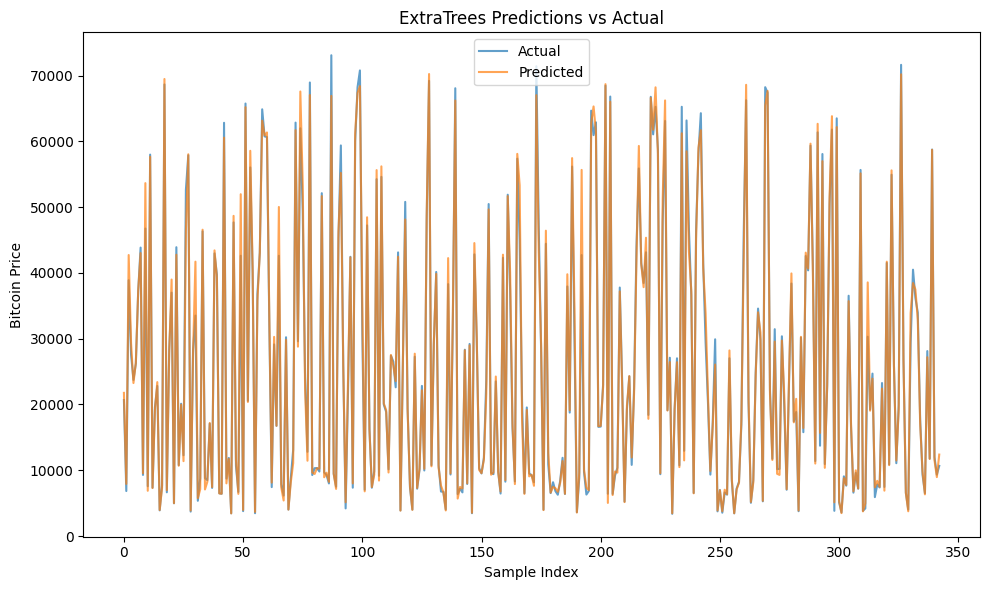

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

model_for_selection = ExtraTreesRegressor(random_state=101)
model_for_selection.fit(features_train, target_train)

selector = SelectFromModel(estimator=model_for_selection, prefit=True)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("feat_selection", selector),
    ("model", ExtraTreesRegressor(random_state=101))
])

pipeline.fit(features_train, target_train)
predictions = pipeline.predict(features_test)

plt.figure(figsize=(10, 6))
plt.plot(target_test.reset_index(drop=True), label="Actual", alpha=0.7)
plt.plot(pd.Series(predictions), label="Predicted", alpha=0.7)
plt.title("ExtraTrees Predictions vs Actual")
plt.xlabel("Sample Index")
plt.ylabel("Bitcoin Price")
plt.legend()
plt.tight_layout()
plt.show()




As we can see above, the actual prices versus the predicted prices are nicely aligned.

---

# GridSeachCV

For a more detailed model selection, we will use GridSearchCV and optimise the hyperparameters for use in our model.

We will again compare the same regressors as above to make sure that Extra Trees is still the top performing algorithm.

In [8]:
from sklearn.pipeline import Pipeline

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor


def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),
    ])

    return pipeline_base

We will use the same Hyperparameter optimisation class that was used in the Churnometer walkthrough project.

This will review the models and supply a dataframe listing the results of each model using the below:
* 'estimator' (Regressor)
* 'min_score'
* 'max_score'
* 'mean_score'
* 'std_score' (Standard Deviation)

In [9]:
from sklearn.model_selection import GridSearchCV
import numpy as np

class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

Here, we use the default parameters of each regressor

In [10]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Now, we import the train and test sets for use in the modelling.  Again, the date is split into 3 columns so that the data is seen as numeric for modelling.

In [11]:
import pandas as pd

features_train = pd.read_csv("outputs/datasets/train_test_initial/features_train.csv")
features_test = pd.read_csv("outputs/datasets/train_test_initial/features_test.csv")
target_train = pd.read_csv("outputs/datasets/train_test_initial/target_train.csv").squeeze()
target_test = pd.read_csv("outputs/datasets/train_test_initial/target_test.csv").squeeze()

# Extract date features
features_train["Year"] = pd.to_datetime(features_train["Date"]).dt.year
features_train["Month"] = pd.to_datetime(features_train["Date"]).dt.month
features_train["Day"] = pd.to_datetime(features_train["Date"]).dt.day

features_test["Year"] = pd.to_datetime(features_test["Date"]).dt.year
features_test["Month"] = pd.to_datetime(features_test["Date"]).dt.month
features_test["Day"] = pd.to_datetime(features_test["Date"]).dt.day

# Drop original Date column
features_train = features_train.drop(columns=["Date"])
features_test = features_test.drop(columns=["Date"])

We then call the HyperparameterOptimizationSearch using the default models and paramaters above.  We fit the train sets to the models and use r2 as our scoring comparison.

In [12]:
import warnings
warnings.filterwarnings("ignore")

search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(features_train, target_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits



Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_spars

Next, we call the score summary and sort it by mean score.  We see that the GridSearchCV yields the same result as the initial review.

Extra Trees regressor has the best mean score and we will use this for Hyperparameter optimisation.

In [13]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.980417,0.983043,0.985187,0.00169
1,DecisionTreeRegressor,0.978537,0.982288,0.984027,0.002005
2,RandomForestRegressor,0.9784,0.982258,0.983821,0.002053
6,XGBRegressor,0.978488,0.982238,0.983985,0.002001
5,GradientBoostingRegressor,0.979559,0.982185,0.983255,0.00138
4,AdaBoostRegressor,0.898135,0.926653,0.954059,0.021411
0,LinearRegression,0.546982,0.654679,0.705163,0.058906


We now intially set model hyperparamters as per the Churnometer walkthrough project (below):

```
params_search = { "ExtraTreesRegressor": { 
    'model__n_estimators': [100, 300], 
    'model__max_depth': [3, 10, None], 
    'model__min_samples_split': [2, 5], 
    'model__min_samples_leaf': [1, 2], }
```

Using the aove, we got the below results:

| Row | Estimator           | Min Score | Mean Score | Max Score | Std Score | Max Depth | Min Samples Leaf | Min Samples Split | N Estimators |
|-----|---------------------|-----------|------------|-----------|-----------|-----------|------------------|-------------------|--------------|
| 23  | ExtraTreesRegressor | 0.985917  | 0.987448   | 0.988910  | 0.001029  | None      | 2                | 5                 | 300          |

Finally, it was decided to centre the params search around these outputs, and so we arrived at the below:

```
params_search = { "ExtraTreesRegressor": { 
    'model__n_estimators': [200, 300, 400], 
    'model__max_depth': [None, 15, 20], 
    'model__min_samples_split': [4, 5, 6], 
    'model__min_samples_leaf': [2, 3], }
```

In [15]:
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_search = {
    "ExtraTreesRegressor": {
        'model__n_estimators': [200, 300, 400],
        'model__max_depth': [None, 15, 20],
        'model__min_samples_split': [4, 5, 6],
        'model__min_samples_leaf': [2, 3],
    }
}

We again call the HyperparameterOptimizationSearch class using the above.

In [16]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(features_train, target_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 54 candidates, totalling 270 fits


We then review the scores and the best parameters.

In [17]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
39,ExtraTreesRegressor,0.985923,0.987479,0.988918,0.001032,20,2,5,200
3,ExtraTreesRegressor,0.98592,0.987478,0.988918,0.001033,None,2,5,200
40,ExtraTreesRegressor,0.98592,0.987451,0.988914,0.001029,20,2,5,300
4,ExtraTreesRegressor,0.985917,0.987448,0.98891,0.001029,None,2,5,300
22,ExtraTreesRegressor,0.985816,0.987442,0.988888,0.001055,15,2,5,300
21,ExtraTreesRegressor,0.985793,0.987435,0.988901,0.001061,15,2,5,200
41,ExtraTreesRegressor,0.985926,0.987433,0.988863,0.001014,20,2,5,400
36,ExtraTreesRegressor,0.986079,0.987432,0.988865,0.000937,20,2,4,200
5,ExtraTreesRegressor,0.985923,0.987432,0.98886,0.001015,None,2,5,400
0,ExtraTreesRegressor,0.986079,0.987425,0.98885,0.000932,None,2,4,200


We see that there is a slight improvement in mean score, Max Depth has improved to 20 and number of estimated is down to 200 from 300:

| Row | Estimator           | Min Score | Mean Score | Max Score | Std Score | Max Depth | Min Samples Leaf | Min Samples Split | N Estimators |
|-----|---------------------|-----------|------------|-----------|-----------|-----------|------------------|-------------------|--------------|
| 39  | ExtraTreesRegressor | 0.985923  | 0.987479   | 0.988918  | 0.001032  | 20        | 2                | 5                 | 200          |

In [27]:
best_model = grid_search_pipelines["ExtraTreesRegressor"].best_estimator_
best_model

Pipeline(steps=[('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model',
                 ExtraTreesRegressor(max_depth=20, min_samples_leaf=2,
                                     min_samples_split=5, n_estimators=200,
                                     random_state=0))])

Finally, we will perform our model evaluation on the train and test sets using the Extra Trees model, which has optimised parameters per the above.

We use the below function, which again came from the Churnometer walkthrough project.

In [30]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def regression_performance(features_train, target_train, features_test, target_test, best_model):
    print("Model Evaluation\n")
    print("* Train Set")
    regression_evaluation(features_train, target_train, best_model)
    print("* Test Set")
    regression_evaluation(features_test, target_test, best_model)

def regression_evaluation(features, target, best_model):
    predictions = best_model.predict(features)
    print('R² Score:', r2_score(target, predictions).round(3))
    print('Mean Absolute Error:', mean_absolute_error(target, predictions).round(3))
    print('Mean Squared Error:', mean_squared_error(target, predictions).round(3))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(target, predictions)).round(3))
    print("\n")

def regression_evaluation_plots(features_train, target_train, features_test, target_test, best_model, alpha_scatter=0.5):
    predictions_train = best_model.predict(features_train)
    predictions_test = best_model.predict(features_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    sns.scatterplot(x=target_train, y=predictions_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=target_train, y=target_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predicted")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=target_test, y=predictions_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=target_test, y=target_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predicted")
    axes[1].set_title("Test Set")

    plt.tight_layout()
    plt.show()


We then call the above functions and review the outputs.

Model Evaluation

* Train Set
R² Score: 0.996
Mean Absolute Error: 733.763
Mean Squared Error: 1512607.25
Root Mean Squared Error: 1229.881


* Test Set
R² Score: 0.991
Mean Absolute Error: 1098.74
Mean Squared Error: 3797420.433
Root Mean Squared Error: 1948.697




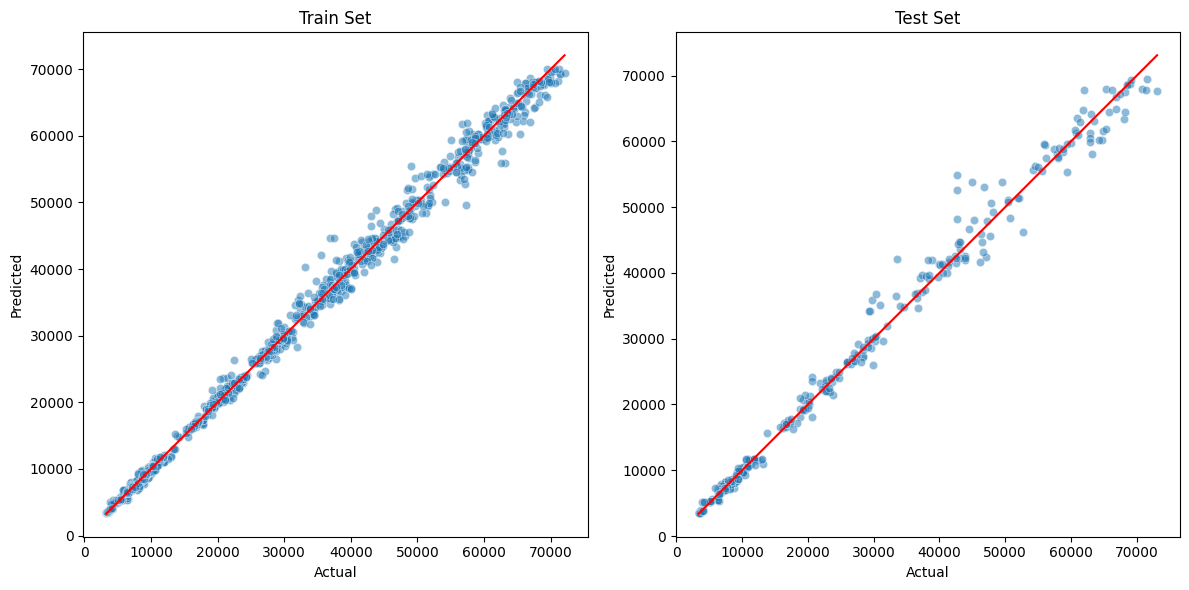

In [ ]:
regression_performance(features_train, target_train, features_test, target_test, best_model)
regression_evaluation_plots(features_train, target_train, features_test, target_test, best_model)

# Summary

In this notebook, we determined that Extra Trees was the best model for our data.  

We performed a hyperparameter search to determine the best parameters for use in our model.

We then evaluated our model using both the Train and Test datasets.  The evaluation is as follows:

| Metric | Train Set | Test Set | Interpretation                                                  |
|--------|-----------|--------- |-----------------------------------------------------------------|
|   R2   |   0.996   |   0.991  | Good generalisation.  Explains 99.1% of variance on unseen data |
|   MAE  |   $734    |   $1,099 | Prediction error is in line for both datasets.                  |
|   RMSE |   $1,230  |   $1,949 | Slight increase on test set                                     |
|   MSE  |   1.5M    |   3.8M   | Higher suqared error on the test set as expected                |

Overall, the model confirms that:
* There is minimal overfitting - The Train and Test scores are close
* The accuracy is consistent - MAE and RMSE are low and stable
* The model handles unseen data with confidence

---

# Push files to the repo

We will generate the following files:

* Modeling pipeline
* Regression evaluation plots

Create the ml_pipeline folder in outputs.

In [37]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_btc_price/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

Save the ML Pipeline.

In [38]:
pipeline_btc = grid_search_pipelines["ExtraTreesRegressor"].best_estimator_
pipeline_btc

Pipeline(steps=[('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model',
                 ExtraTreesRegressor(max_depth=20, min_samples_leaf=2,
                                     min_samples_split=5, n_estimators=200,
                                     random_state=0))])

In [39]:
joblib.dump(value=pipeline_btc, filename=f"{file_path}/btc_pipeline.pkl")

['outputs/ml_pipeline/predict_btc_price/v1/btc_pipeline.pkl']

We will also copy our .png files from the data analysis workbook

In [41]:
import os
import shutil
import glob

source_folder = "outputs/datasets/figs/"
destination_folder = "outputs/ml_pipeline/predict_btc_price/v1/"

os.makedirs(destination_folder, exist_ok=True)

image_files = glob.glob(os.path.join(source_folder, "*.png"))

for file_path in image_files:
    shutil.copy(file_path, destination_folder)

